In [1]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_masks_XYZ import Scalar_mask_XYZ
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.utils_optics import beam_width_2D, field_parameters, normalize_field
from scipy.constants import c, epsilon_0, e, m_e, h
import numpy as np
import sympy as sp

from sympy.core.numbers import pi
from IPython.display import display
import numba
from numbalsoda import dop853, lsoda, lsoda_sig
from numba import njit, cfunc
from numpy.lib.scimath import sqrt as csqrt
from numpy.fft import fft2, ifft2, fftshift
from numba_progress import ProgressBar

In [2]:
numba.jit(nopython = True, cache=True)
def PWD_kernel(Ek, n, k0, k_perp2, dz):
    """
    Step for scalar(TE) Plane wave decomposition(PWD) algorithm.

    Parameters:
        u(np.array): field
        n(np.array): refraction index
        k0(float): wavenumber
        k_perp(np.array): transversal k
        dz(float): increment in distances

    Returns:
        (numpy.array): Field at at distance dz from the incident field

    References:
        1. Schmidt, S. et al. Wave - optical modeling beyond the thin - element - approximation. Opt. Express 24, 30188 (2016).

    """
    H = np.exp(1j * dz * csqrt(n**2 * k0**2 - k_perp2))

    return ifft2(fftshift(H * Ek))

numba.jit(nopython = True, inline= True, cache=True)
def WPM_schmidt_kernel(u, n, k0, k_perp2, dz, ):
    """
    Kernel for fast propagation of WPM method

    Parameters:
        u (np.array): fields
        n (np.array): refraction index
        k0 (float): wavenumber
        k_perp2 (np.array): transversal k**2
        dz (float): increment in distances

    References:

        1. M. W. Fertig and K.-H. Brenner, “Vector wave propagation method,” J. Opt. Soc. Am. A, vol. 27, no. 4, p. 709, 2010.

        2. S. Schmidt et al., “Wave-optical modeling beyond the thin-element-approximation,” Opt. Express, vol. 24, no. 26, p. 30188, 2016.
    """
    refraction_indexes = np.unique(n)

    u_final = np.zeros_like(u, dtype=complex)
    Ek = fftshift(fft2(u))
    for n_m in refraction_indexes:
        Imz = (n == n_m)
        u_final += Imz * ifft2(fftshift(np.exp(1j * dz * csqrt(n_m**2 * k0**2 - k_perp2)) * Ek))

    return u_final

numba.jit(nopython = True, inline= True, cache=True)
def WPM(x0, y0, z0, t0, wavelength, progress_proxy):
    k0 = 2 * np.pi / wavelength

    x = x0
    y = y0
    z = z0
    
    t0.u[:, :, 0] = t0.u0.u
    
    num_x = len(x)
    num_y = len(y)
    
    dx = x[1] - x[0]
    kx = 2 * np.pi / (num_x * dx) * (range(-int(num_x / 2), int(
        num_x / 2)))
    
    dy = y[1] - y[0]
    ky = 2 * np.pi / (num_y * dy) * (range(-int(num_y / 2), int(
        num_y / 2)))

    KX, KY = np.meshgrid(kx, ky)

    k_perp2 = KX**2 + KY**2

    filter_edge = 1
    dz = z[1] - z[0]
    
    num_steps = len(t0.z)
    for j in range(1, num_steps):

        t0.u[:, :, j] = t0.u[:, :, j] + WPM_schmidt_kernel(
            t0.u[:, :, j - 1], t0.n[:, :, j - 1], k0, k_perp2,
            dz) * filter_edge
        
        progress_proxy.update(1)
    
numba.jit(nopython = True, inline= True, cache=True, fastmath=True)
def WPM_inplace(x0, y0, z0, t0, wavelength, progress_proxy):
    k0 = 2 * np.pi / wavelength

    x = x0
    y = y0
    z = z0

    num_x = len(x)
    num_y = len(y)
    
    dx = x[1] - x[0]
    kx = 2 * np.pi / (num_x * dx) * (range(-int(num_x / 2), int(
        num_x / 2)))
    
    dy = y[1] - y[0]
    ky = 2 * np.pi / (num_y * dy) * (range(-int(num_y / 2), int(
        num_y / 2)))

    KX, KY = np.meshgrid(kx, ky)

    k_perp2 = KX**2 + KY**2

    filter_edge = 1
    dz = z[1] - z[0]
    
    num_steps = len(t0.z)
    for j in range(1, num_steps):
        u0 = t0.u
        t0.u +=  WPM_schmidt_kernel(
            u0, t0.n[:, :, j - 1], k0, k_perp2,
            dz) * filter_edge
        
        progress_proxy.update(1)


In [10]:
X, Y, Z = sp.symbols('X Y Z')

#Use scipy's constants
e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0 #8.85418782e-12 #permittivity unit F/m
#eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

#Set initial accelerating voltage. I know it's unrealistic but it gives an output that is easy to plot for now.
phi_0 = 60e5

#Calculate corresponding wavelength of the electron, and divide by 1e-6 so that everything is scaled around the micron unit (this is for the diffractio package)
wavelength = h/(2*abs(e)*m*phi_0)**(1/2)/1e-6

#Set voltage of biprism
V = 200

#Set radius of biprism wire
r = 0.125e-6/1e-6

#Set radius of the condenser surrounding the wire
R = 1e-3/1e-6

phi_biprism = V*(sp.log((X*X+(Z)**2)/(R**2)))/(2*sp.log(r/R))

#Here we write the "refractive index" that the electron would see, using the equation for the electrostatic potential. See Eq 5.17 in Hawkes Principles of Electron Optics
n_eq1 = (1+phi_biprism/phi_0)**(0.5)
n_eq1_lambda = sp.lambdify([Z, X, Y], n_eq1)

#Set up the scale in x and z
x0 = np.linspace(-0.4 * um, 0.4 * um, 128 * 1)
y0 = np.linspace(-0.4 * um, 0.4 * um, 128 * 1)
z0 = np.linspace(-10 * mm, 80 * mm,  1000 * 1)
xx0, yy0, zz0 = np.meshgrid(x0, y0, z0)

#Create a source plane wave
u0 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
u0.plane_wave(A=1, z0=0 * um, theta=0. * degrees)

t0 = Scalar_mask_XYZ(x=x0, y=y0, z=z0, wavelength=wavelength, n_background=0)
t0.incident_field(u0)

#Create the biprism volume
t0.n = np.complex128(n_eq1_lambda(zz0, xx0, yy0))
t0.cylinder(r0=(0, 0, 0), radius=(r * um, r * um), length = r, refraction_index=0 + 10j, axis = 0, angle = 0)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [11]:
print(wavelength)
dx = x0[1] - x0[0]
dz = z0[1] - z0[0]

print("x = {:2.5f}, z = {:2.2f}".format(dx, dz))
print("x/wavelength = {:2.5f}, z/wavelength = {:2.2f}".format(
    dx / wavelength, dz / wavelength))

5.006863040645561e-07
x = 0.00630, z = 20.02
x/wavelength = 12581.15620, z/wavelength = 39985156.09


In [12]:
#Perform the calculation with the wave propagation method
t0.WPM(verbose=True, has_edges=False)

Time = 54.24 s, time/loop = 54.24 ms


In [5]:
#t0.u = u0.u
#with ProgressBar(total=len(z0)) as progress:
   # WPM(x0, y0, z0, t0, wavelength, progress)

In [13]:
t0.u.shape

(128, 128, 1000)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f83440650f0>)

<Figure size 640x480 with 0 Axes>

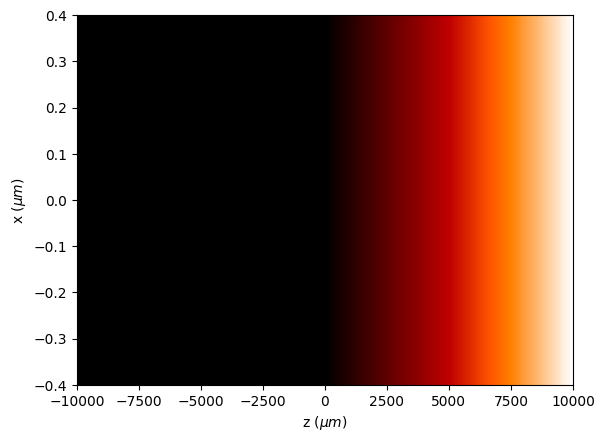

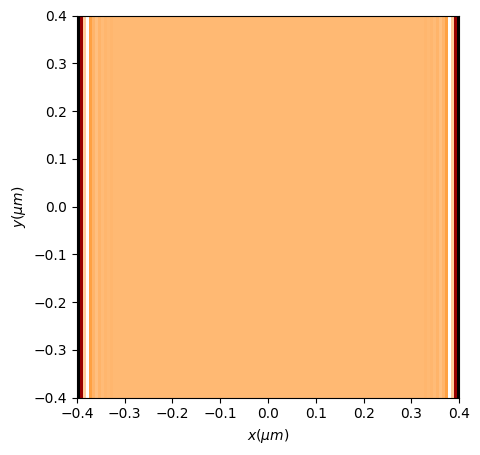

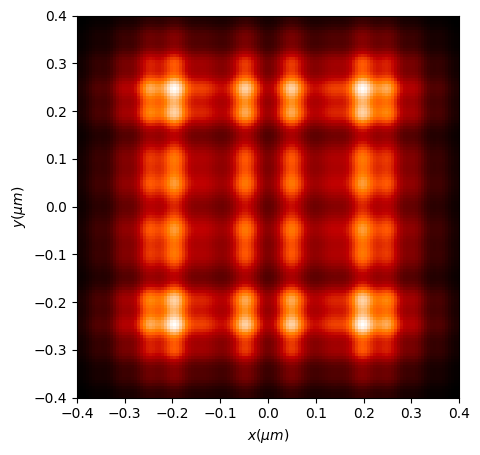

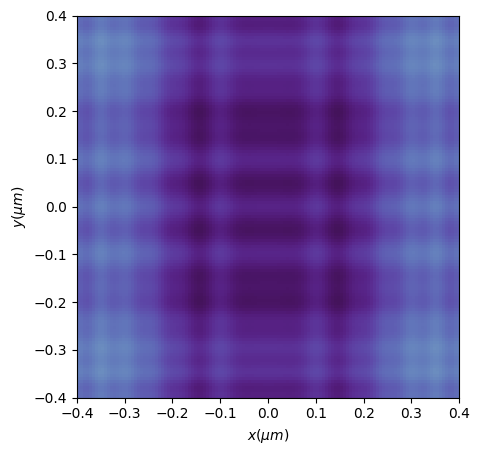

In [16]:
t0.draw_XZ(y0=0, draw_borders=True)
#t0.draw_XY(z0=1 * mm)

u_xy = t0.to_Scalar_field_XY(z0=1 * mm, is_class=True, matrix=False)
u_xy.draw(kind='intensity')

#u2 = Scalar_mask_XY(x=x0, y=y0, wavelength=wavelength)
#u2.incident_field(t0.u[:, :, -1])
u2 = u_xy.RS(z=80 * mm, new_field=True)
u2.draw(kind='intensity')
u2.draw(kind='phase')